In [1]:
source("../wwa_model-fitting.R")

In [95]:
# fit linear GEV trend to all grid cells
y1 <- 1979
fittype <- "shiftscale"

df <- merge(read.table("gmst.dat", col.names = c("year", "gmst")), read.csv("era5_maxt2m_land.csv", skip = 2))
df <- df[df$year >= y1,]

models <- lapply(colnames(df)[-(1:2)], function (cnm) { tryCatch(fit_ns("gev", fittype, df[,c("year", "gmst", cnm)], cnm, "gmst"), error = function(cond) return(NULL)) })

npars <- length(models[[1]]$par)

In [96]:
# save model parameters
write.csv(sapply(models, function(mdl) if(is.null(unlist(mdl)[1])) return(rep(NA, npars)) else return(mdl$par)),
    paste0("fitted_",y1,"-2023_",fittype,"_model-pars.csv"))

In [ ]:
# save exceedances
xc = abind(sapply(models, function(mdl) if(is.null(unlist(mdl)[1])) return(matrix(nrow = nrow(df), ncol = 199)) else return((mdl$x - eff_return_level(mdl, 2:200)) > 0), simplify = F), along = 0)
save(xc, file = paste0("fitted_",y1,"-2023_",fittype,"_exceedances.csv"))

In [98]:
xc_counts <- apply(xc, 3, sum, na.rm = T) / (952*74)

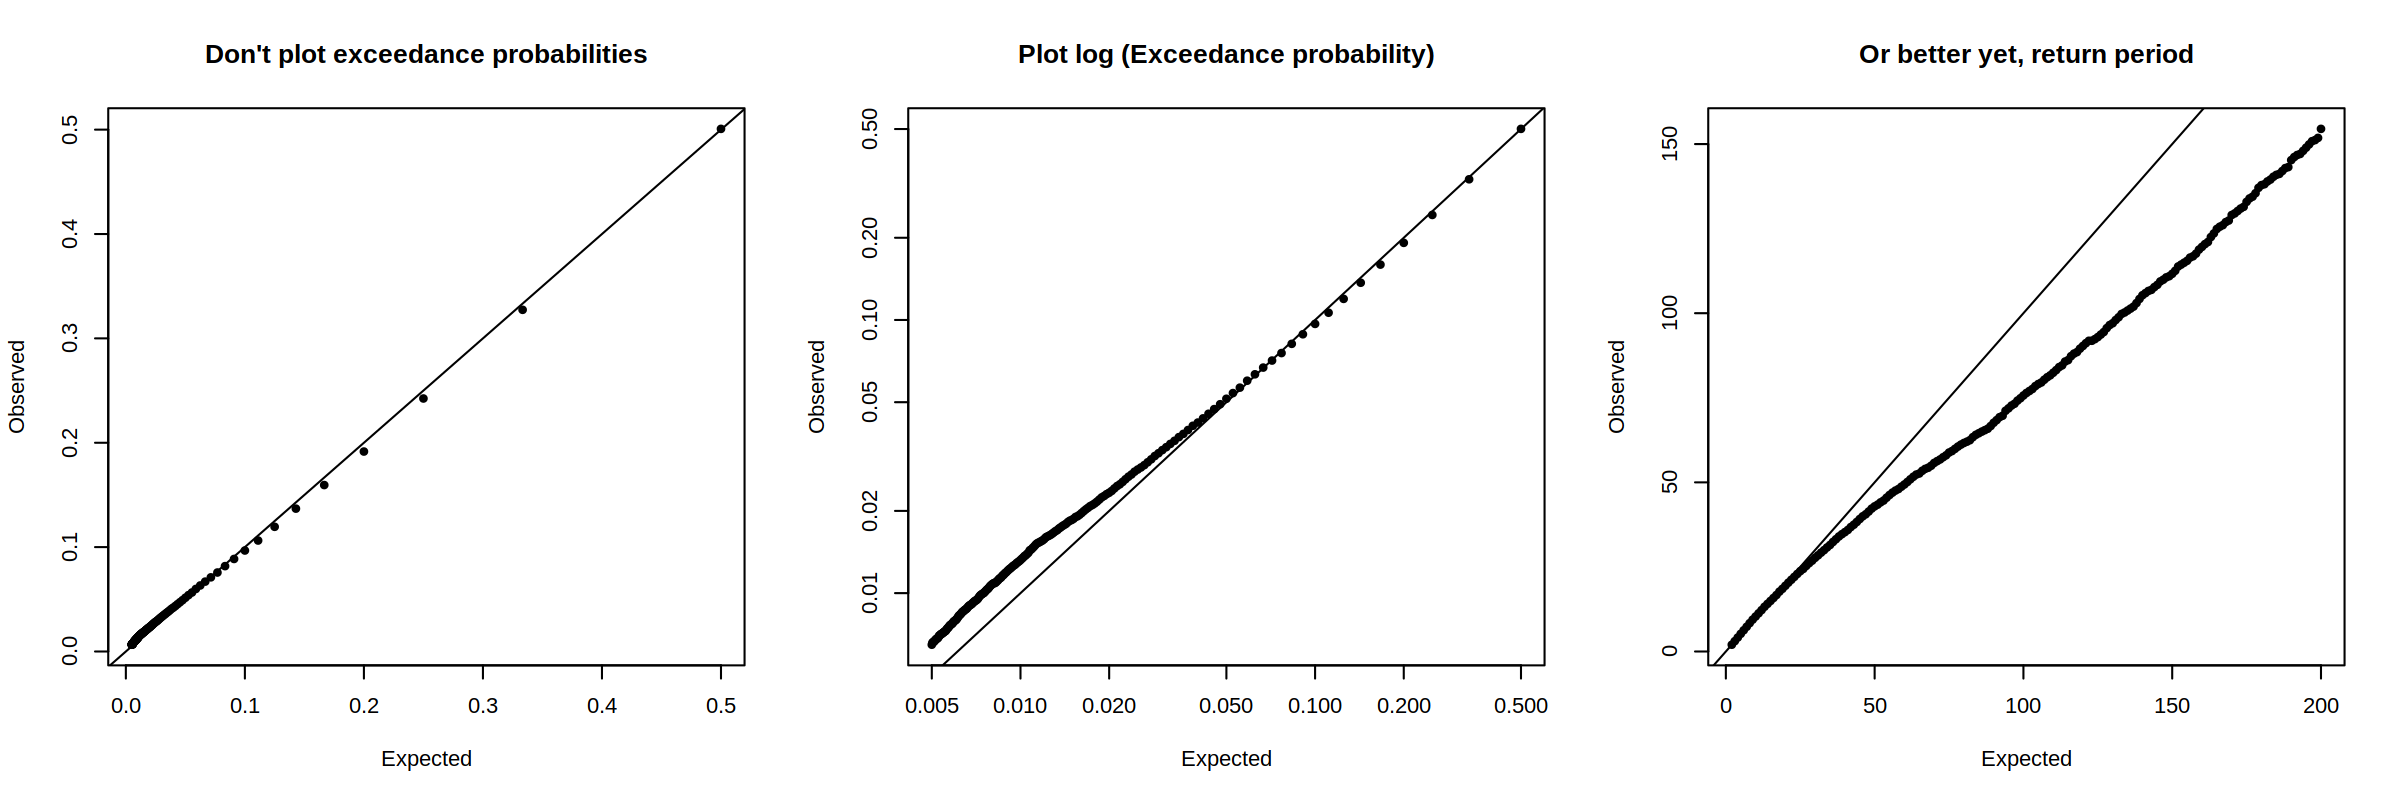

In [113]:
# important to plot exceedances on appropriate scales
prep_window(c(1,3))
plot(1/(2:200), xc_counts, xlab = "Expected", ylab = "Observed", log = "", main = "Don't plot exceedance probabilities")
abline(0,1)

plot(1/(2:200), xc_counts, xlab = "Expected", ylab = "Observed", log = "xy", main = "Plot log (Exceedance probability)")
abline(0,1)

plot(2:200, 1/xc_counts, xlab = "Expected", ylab = "Observed", main = "Or better yet, return period")
abline(0,1)